<a href="https://colab.research.google.com/github/Mariscal6/MLPy/blob/main/ejer2sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" Cualquier librería adicional que necesiteis durante el ejercicio, importadlo en esta sección """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Ejercicio 2
Este ejercicio pretende poner en práctica la habilidad de limpiar datos y visualizar plots en para crear finalmente modelos en sklearn.

El estudiante tendrá que repasar los comandos realizados en clase y lidiar con posibles errores durante el desarrollo.

Para facilitar y agilizar el desarrollo, el estudiante tendrá que rellenar los huecos marcados como '# codigo-alumno'. No obstante, si además el estudiante necesita ejecutar código adicional, siempre podrá utilizar cualquier celda adicional.

El estudiante tendrá siempre que introducir una semilla (seed) que generará acorde a su fecha de nacimiento (sin ser intrusivos en edad).

Finalmente, la entrega será un fichero .ipynb cambiando nombre y apellido al fichero.

In [ ]:
""" El estudiante tendrá que utilizar la semilla proporcionada para todos los procesos aleatorios """

seed = 6 + 13 * 11

In [ ]:
!pip install scikit-learn -U

     |████████████████████████████████| 22.2MB 1.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


### Data cleansing


In [ ]:
""" Leed el dataframe de sklearn llamado 'fetch_kddcup99' y almacenarlo en una variable llamada data """

from sklearn.datasets import fetch_kddcup99

data = fetch_kddcup99(as_frame=True)
pd_data = data.frame
pd_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,1,0,0,9,9,1,0,0.11,0,0,0,0,0,b'normal.'
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,1,0,0,19,19,1,0,0.05,0,0,0,0,0,b'normal.'
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,1,0,0,29,29,1,0,0.03,0,0,0,0,0,b'normal.'
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0,0,0,0,1,0,0,39,39,1,0,0.03,0,0,0,0,0,b'normal.'
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0,0,0,0,1,0,0,49,49,1,0,0.02,0,0,0,0,0,b'normal.'


In [ ]:
""" De entre todas las variables del dataframe, solo trabajaremos en 
    este ejercicio con las descritas en key_columns, por lo que tendréis que quitar el resto """

key_columns = ['duration', 'protocol_type', 'service', 'flag', 'logged_in', 'count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate', 'labels']

pd_data = pd_data[key_columns]
pd_data.head()

,duration,protocol_type,service,flag,logged_in,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
0,0,b'tcp',b'http',b'SF',1,8,8,0,9,0,b'normal.'
1,0,b'tcp',b'http',b'SF',1,8,8,0,19,0,b'normal.'
2,0,b'tcp',b'http',b'SF',1,8,8,0,29,0,b'normal.'
3,0,b'tcp',b'http',b'SF',1,6,6,0,39,0,b'normal.'
4,0,b'tcp',b'http',b'SF',1,6,6,0,49,0,b'normal.'


In [ ]:
""" Comprobad que no haya nulos ni registros duplicados """
# Compruebo que no hay registros nulos
pd_data.isnull().sum()


duration                    0
protocol_type               0
service                     0
flag                        0
logged_in                   0
count                       0
srv_count                   0
serror_rate                 0
dst_host_srv_count          0
dst_host_srv_serror_rate    0
labels                      0
dtype: int64

Como podemos ver no hay registros nulos, por lo que no hacemos nada.

In [ ]:
# Compruebo que si hay duplicados 
pd_data.duplicated().sum()

439856

Si hay duplicados por lo que procedo a quitarlos

In [ ]:
pd_data = pd_data[~pd_data.duplicated()]
pd_data.duplicated().sum()

0

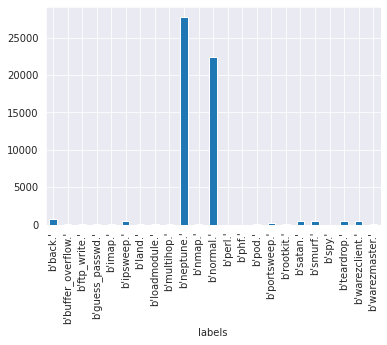

In [ ]:
""" Mostrar un barplot para la variable objetivo (labels)"""

target = 'labels'

k = pd_data.groupby([target]).size()

k.plot(kind='bar')
plt.show()

In [ ]:
""" Dado que hay dos etiquetas que se repiten con mayor frecuencia, 
    transformad la variable labels para que tenga un valor booleano que indique 
    si es la etiqueta más frecuente o la segunda más frecuente, 
    los demás registros los eliminaremos de este estudio """

# Saco en un diccionario las dos categorías más frecuentes, y asigno true y false
top_labels = pd_data.groupby('labels').size().sort_values(ascending=False)[:2]
top_labels[:] = (True,False)

# Si no está en las dos categorías mas frecuentes te elimino
pd_data = pd_data[pd_data.labels.isin(top_labels.keys())]
# Si está te cambio a true o false, según si es la más frecuente o la menos
pd_data.labels= pd_data.labels.apply(lambda x: top_labels[x])

print(len(pd_data))
top_labels = pd_data.groupby('labels').size().sort_values(ascending=False)
print(top_labels)

50177
labels
True     27722
False    22455
dtype: int64


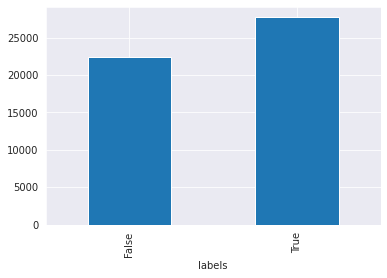

In [ ]:
""" Volved a mostrar el barplot para la variable objetivo (labels) """

# codigo-alumno
k = pd_data.groupby([target]).size()

k.plot(kind='bar')
plt.show()

In [ ]:
""" Separaremos las variables categóricas de las numéricas """


num_cols = ['duration', 'count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate']
cat_cols = ['protocol_type', 'service', 'flag', 'logged_in']

pd_data[num_cols] = pd_data[num_cols].astype(float)

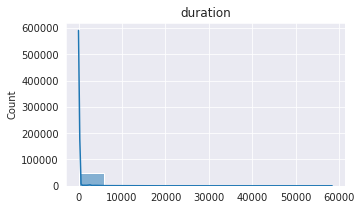

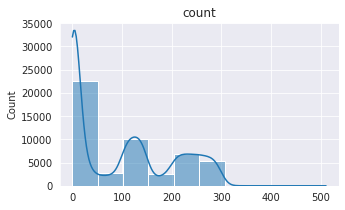

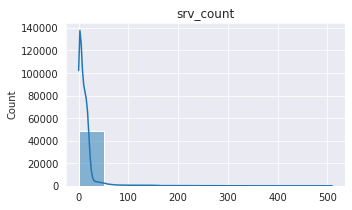

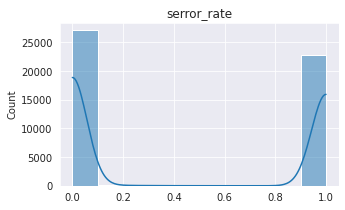

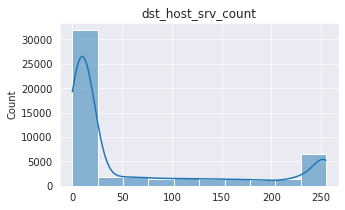

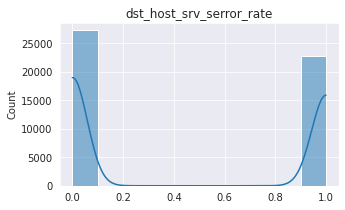

In [ ]:
""" Mostrad un histograma por cada variable numérica """

for n_var in num_cols:
  plt.figure(figsize=(5,3))
  plt.title(n_var)
  sns.histplot(x=n_var, data=pd_data, kde=True, bins=10)
  plt.xlabel('')
  plt.show()

In [ ]:
""" Por la forma de los histogramas, podría ser un buen estudio convertir las variables
    numéricas a variables dummy, es lo que hareis en este apartado y, por tanto, pasarán 
    a ser categóricas todas las variables del dataframe. Esta parte será libre para el 
    estudiante. Deberá tomar la decisión que considere más apropiada para realizar esta 
    binarización """


' Por la forma de los histogramas, podría ser un buen estudio convertir las variables\n    numéricas a variables dummy, es lo que hareis en este apartado y, por tanto, pasarán \n    a ser categóricas todas las variables del dataframe. Esta parte será libre para el \n    estudiante. Deberá tomar la decisión que considere más apropiada para realizar esta \n    binarización '

Primero voy a ver como son los datos, también numéricamente

In [ ]:
pd_data.describe()

,duration,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate
count,50177.000000,50177.000000,50177.000000,50177.000000,50177.000000,50177.000000
mean,275.013911,103.591107,13.796142,0.456563,67.326285,0.455674
std,1632.164746,101.473094,26.765763,0.496846,89.241232,0.496898
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,2.000000,0.000000,7.000000,0.000000
50%,0.000000,101.000000,8.000000,0.000000,16.000000,0.010000
75%,0.000000,203.000000,16.000000,1.000000,114.000000,1.000000
max,58329.000000,511.000000,510.000000,1.000000,255.000000,1.000000


Nos fijamos en la tabla anterior además de los histogramas para elegir las categorías que vamos a utilizar:


*   **Duration**,  **srv_count**, **serror_rate**, **serror_rate**, **dst_host_srv_serror_rate**, **dst_host_srv_count** tienen los datos polarizados, tienen mucha cantidad de valores concentrados en una o dos zonas, por lo que lo mejor es separarlos en dos categorías, utilizando la mediana.

*   Para **count** diferenciaremos 3 categorías, si count está entre 0 y 10, de 10 a 140, y mayor de 140, para que las categorías queden homogéneas


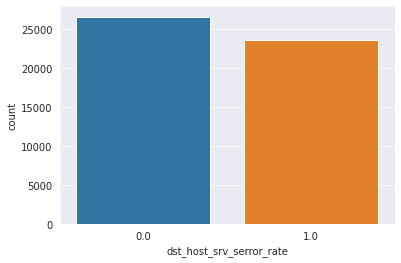

In [ ]:
# Variables con dos categorías marcadas, categorizamos utilizandos la mediana (0 en todas exceto en server_count)
bin_cols = ['duration', 'srv_count', 'serror_rate', 'dst_host_srv_serror_rate','dst_host_srv_count']
for bin_var in bin_cols:
  pd_data[bin_var] = Binarizer(threshold= np.median(pd_data[[bin_var]])).fit_transform(pd_data[[bin_var]])

# Count
pd_data['count'] = pd_data['count'].apply(lambda x: 'count<10' if x<10 else ('count[10,140]' if x < 140 else 'count>140'))
# Dst_host_srv_count
#pd_data['count_cat'] = pd_data['dst_host_srv_count'].apply(lambda x: 'count<10' if x<10 else ('count[10,140]' if x < 140 else 'count>140'))
sns.countplot(pd_data['dst_host_srv_serror_rate'])

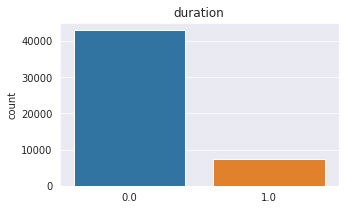

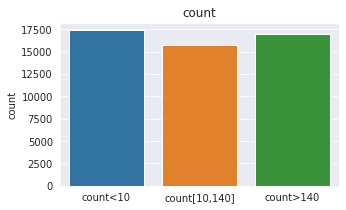

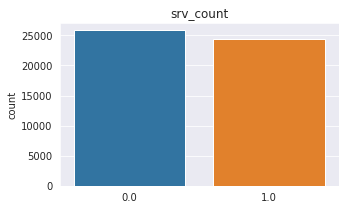

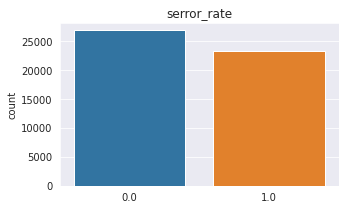

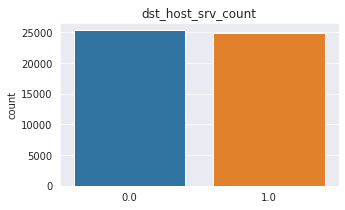

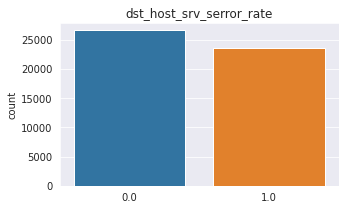

In [ ]:
""" Mostrad un barplot por cada variable """
for var in num_cols:
  plt.figure(figsize=(5,3))
  plt.title(var)
  sns.countplot(pd_data[var])
  plt.xlabel('')
  plt.show()

In [ ]:
""" Transformad la variable service en una variable dummy que nos permitan identificar el servicio
    más frecuente frente al resto """

most_frecuent_service = pd_data.groupby('service').size().sort_values(ascending=False)[:1].keys()[0]
pd_data['service']= pd_data.service.apply(lambda x: 1 if x==most_frecuent_service else 0)
pd_data.groupby('service').size().sort_values(ascending=False)

service
0    27462
1    22715
dtype: int64

In [ ]:
most_frecuents_flags = pd_data.groupby('flag').size().sort_values(ascending=False)[:2].keys()
most_frecuents_flags

Index([b'S0', b'SF'], dtype='object', name='flag')

In [ ]:
""" Transformad la variable flag en dos variables dummy que nos permitan identificar 3 tipos de flags, 
    los dos más comunes y el resto """

most_frecuents_flags = pd_data.groupby('flag').size().sort_values(ascending=False)[:2].keys()
pd_data['flag']= pd_data.flag.apply(lambda x: x if x in most_frecuents_flags else 'Other')
pd_data.groupby('flag').size().sort_values(ascending=False)

flag
b'S0'    22846
b'SF'    21553
Other     5778
dtype: int64

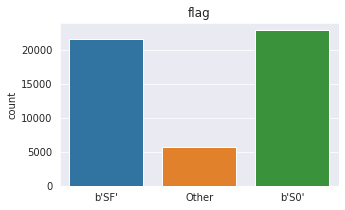

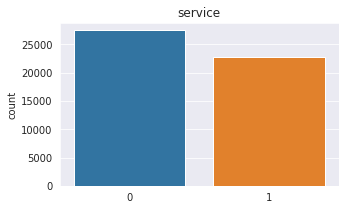

In [ ]:
""" Volved a mostrad un barplot por cada variable """

for var in ['flag','service' ]:
  plt.figure(figsize=(5,3))
  plt.title(var)
  sns.countplot(pd_data[var])
  plt.xlabel('')
  plt.show()

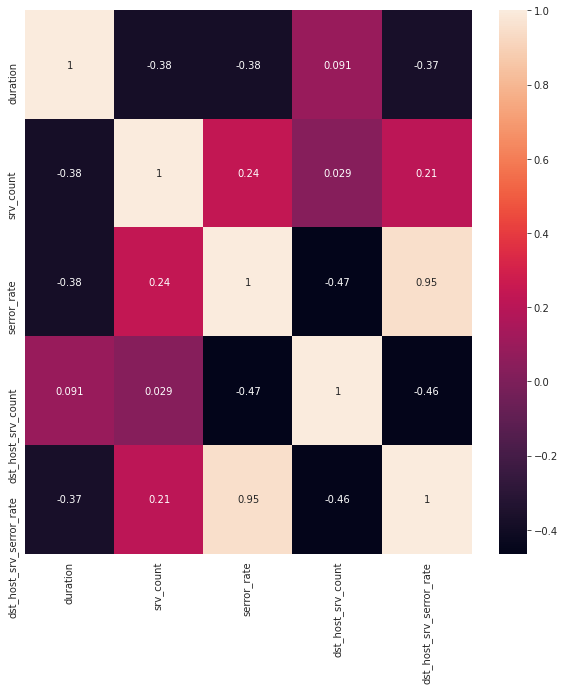

In [ ]:
""" Mostrad un plot de correlaciones entre variables numéricas """
plt.figure(figsize=(10,10))
sns.heatmap(pd_data[num_cols].corr(), annot=True)
plt.show()

Veo si tengo más duplicados

In [ ]:

pd_data.duplicated().sum()

50019

Procedo a eliminarlos

In [ ]:
pd_data = pd_data[~pd_data.duplicated()]
pd_data.duplicated().sum()

0

In [ ]:
pd_data.shape

(158, 11)

Veo las categorías de cada variable


In [ ]:
categories = {}
for col in pd_data:
    print(f'{col} : {pd_data[col].unique()}')
    categories[col] = pd_data[col].unique()

duration : [0. 1.]
protocol_type : [b'tcp' b'udp' b'icmp']
service : [0 1]
flag : [b'SF' 'Other' b'S0']
logged_in : [1 0]
count : ['count<10' 'count[10,140]' 'count>140']
srv_count : [0. 1.]
serror_rate : [0. 1.]
dst_host_srv_count : [0. 1.]
dst_host_srv_serror_rate : [0. 1.]
labels : [False  True]


### Model evaluation

In [ ]:
""" Realizad una evaluación de, al menos, cinco modelos de machine learning con
    la técnica de validación cruzada más acertada (10 splits). Además, se pide
    incorporar, al menos, una técnica de selección previa de las 1, 2 o 3 features que
    mejores resultados ofrezca (Nota, tendreis que usar OneHotEncoder para las variables 
    que tengan strings) """


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Transformo las variables que contienen categorías como strings y como bytes 
col_transformer = ColumnTransformer([
    ("encoder_tipo1", OneHotEncoder(categories=[[b'tcp', b'udp', b'icmp']], drop='first'), ['protocol_type']),
    ("encoder_tipo2", OneHotEncoder(categories=[[b'SF', 'Other', b'S0']], drop='first'), ['flag']),
    ("encoder_tipo3", OneHotEncoder(categories=[['count<10', 'count[10,140]', 'count>140']], drop='first'), ['count'])
])

# Selecciono modelos 
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('ADA', AdaBoostClassifier()))

X = pd_data.drop(target, axis=1) 
y = pd_data[target]

results = []
names = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

for name, model in models:
    
    #Recursive Feature Elimination (RFE) como selector de las tres variables con más importancia
    pipeline = make_pipeline(col_transformer, RFE(model,3), model)

    #  Los folds se hacen preservando el porcentaje de cada clase
    cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    #  Utilizo balanced_accuracy para que me de una media, de las medias de cada clase, puesto que nuestros datos 
    #  de la variable objetivo están desbalanceado
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=cv_technique, scoring='balanced_accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    results.append(cv_results)
    names.append(name)
    

LR: 0.813333 (0.122656)
DTC: 0.846667 (0.170750)
RFC: 0.896667 (0.106927)
GBC: 0.896667 (0.106927)
ADA: 0.896667 (0.106927)


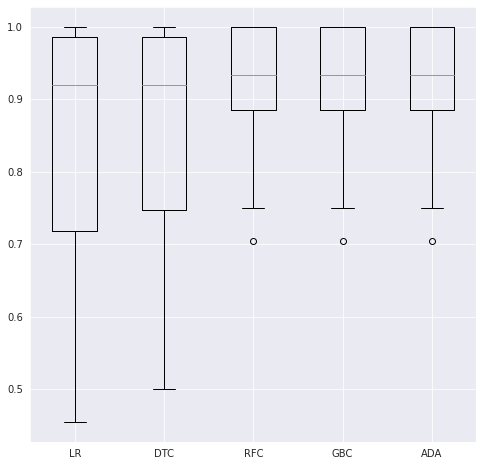

In [ ]:
def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

boxplots_algorithms(results, names)

En este caso me quedaria con cualquiera de estos tres:


1.  RandomForestClassifier

2. GradientBoostingClassifier

3.   AdaBoostClassifier

